In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
ted = pd.read_csv('ted_main.csv')
transcripts = pd.read_csv('ted_transcripts.csv')

# Data Preprocessing

Converting time formats

In [3]:
ted['film_date'] = ted['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['published_date'] = ted['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['film_month'] = ted['film_date'].apply(lambda x: x.month)
ted['pub_month'] = ted['published_date'].apply(lambda x: x.month)
ted['film_weekday'] = ted['film_date'].apply(lambda x: x.weekday()) # Monday: 0, Sunday: 6
ted['pub_weekday'] = ted['published_date'].apply(lambda x: x.weekday())

Defining a column Popular/Not popular for videos with 7 million+ views.

In [4]:
ted['Popularity']=np.where(ted['views']>700000,1,0)

Plotting Views

C:\Users\DELL\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


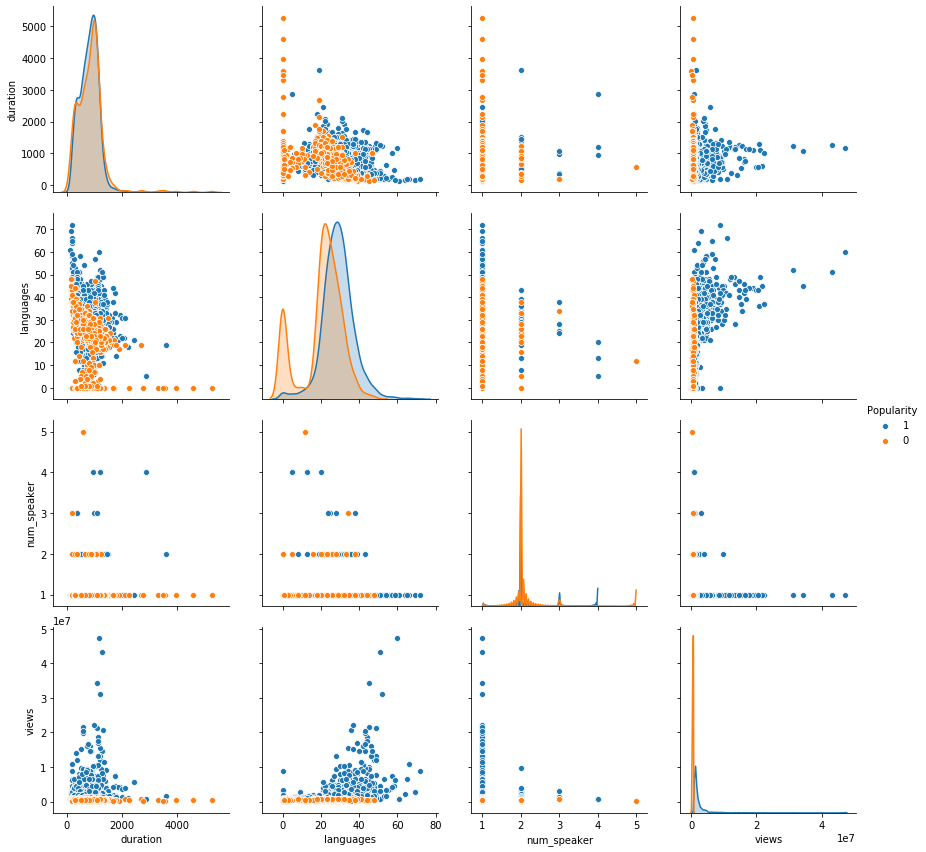

In [5]:
nums = ['duration', 'languages', 'num_speaker', 'views']
sns.pairplot(ted, vars=nums,hue = 'Popularity' , hue_order = [1,0], diag_kind='kde', size=3);

Popular talks by day of week

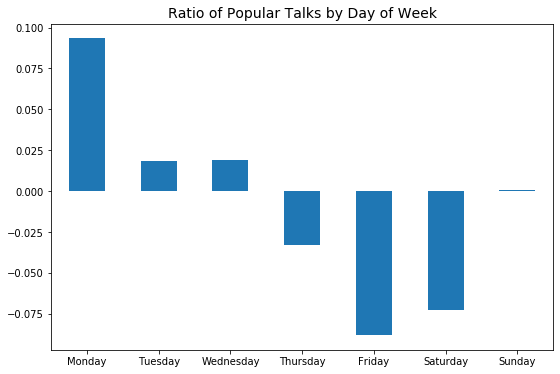

In [7]:
overall_mean_popular = np.mean(ted.Popularity)
fw = ted.groupby('film_weekday')['Popularity'].mean().round(4) - overall_mean_popular
pw = ted.groupby('pub_weekday')['Popularity'].mean().round(4) - overall_mean_popular
by_weekday = fw
#by_weekday.columns = ['Filmed', 'Published']
by_weekday.index = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
by_weekday.plot(kind='bar', figsize=(9,6))
plt.title('Ratio of Popular Talks by Day of Week', fontsize=14)
plt.xticks(rotation=0)
plt.show()



Visualizing Tags

In [8]:
count_vector = CountVectorizer(stop_words='english',min_df=20/len(ted)) # Only keep those with 20 or more occurrences
tag_array = count_vector.fit_transform(ted.tags).toarray()
tag_matrix = pd.DataFrame(tag_array, columns = count_vector.get_feature_names())
all_tags = tag_matrix.columns
tag_matrix = pd.concat([tag_matrix, ted.Popularity], axis=1)
by_tag = dict()
for col in all_tags:
    by_tag[col]=tag_matrix.groupby(col)['Popularity'].mean()[1] - overall_mean_popular
tag_rank = pd.DataFrame.from_dict(by_tag, orient='index')
tag_rank.columns = ['pop_rate_diff']


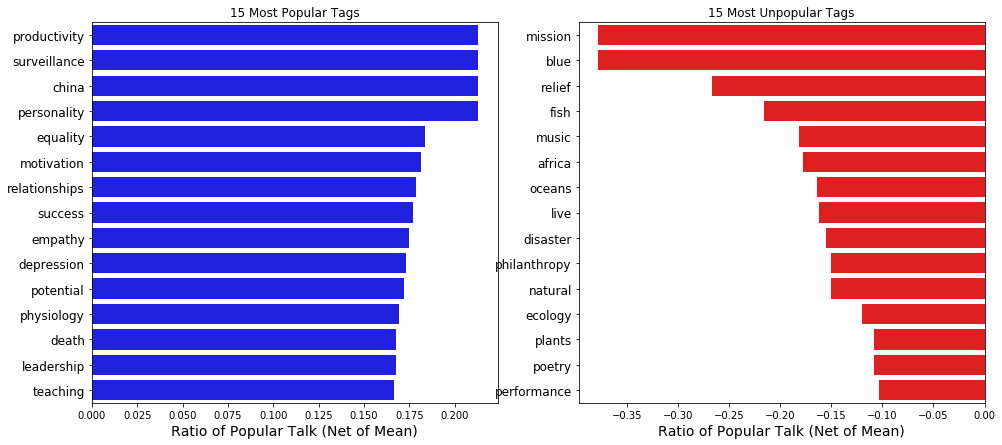

In [37]:
plt.figure(figsize=(16,7))
plt.subplot(121)
bar_2 = tag_rank.sort_values(by='pop_rate_diff', ascending=False)[:15]
sns.barplot(x=bar_2.pop_rate_diff, y=bar_2.index, color='blue')
plt.title('15 Most Popular Tags')
plt.xlabel('Ratio of Popular Talk (Net of Mean)', fontsize=14)
plt.yticks(fontsize=12)
plt.subplot(122)
bar_1 = tag_rank.sort_values(by='pop_rate_diff')[:15]
sns.barplot(x=bar_1.pop_rate_diff, y=bar_1.index, color='red')
plt.title('15 Most Unpopular Tags')
plt.xlabel('Ratio of Popular Talk (Net of Mean)', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

# Implementing Naive Bayes classification

In [48]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

In [17]:
y = ted.Popularity #Set target variable

In [41]:
cv_t = CountVectorizer(stop_words='english', max_features=10000, lowercase=True) # Title
cv_d = CountVectorizer(stop_words='english', max_features=1000, lowercase=True) # Description

In [43]:
x_t = cv_t.fit_transform(ted.title)
x_d = cv_d.fit_transform(ted.description)

In [45]:
x_all = hstack([x_t, x_d]) #Merging

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y, test_size=0.25, random_state=36)

In [50]:
from sklearn.naive_bayes import MultinomialNB

In [14]:
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from time import time

def train_predict(clf, parameters):
        
    clf.fit(x_train, y_train)
    scorer = make_scorer(fbeta_score, beta=1)

    # 5-fold cross validation
    start = time()

    grid_obj = GridSearchCV(clf, parameters, cv=5, scoring=scorer)
    grid_fit = grid_obj.fit(x_train, y_train)
    best_clf = grid_fit.best_estimator_
    best_prob_train = best_clf.predict_proba(x_train)
    best_prob = best_clf.predict_proba(x_test)
    best_pred_train = (best_prob_train[:,1]>0.65)*1
    best_pred = (best_prob[:,1]>0.65)*1

    end = time()

    run_time = end - start

    # Report results
    print (clf.__class__.__name__ + ":")
    print ("Accuracy score on training data : {:.4f}".format(best_clf.score(x_train, y_train)))
    print ("Accuracy score on testing data : {:.4f}".format(best_clf.score(x_test, y_test)))
    return best_prob_train, best_prob, best_pred_train, best_pred

In [59]:
clf2 = MultinomialNB()
parameters={}
nb_prob_train, nb_prob, nb_pred_train, nb_pred = train_predict(clf2, parameters)

MultinomialNB:
Accuracy score on training data : 0.9090
Accuracy score on testing data : 0.7571


In [60]:
pd.DataFrame(confusion_matrix(y_train, nb_pred_train))

,0,1
0,296,121
1,29,1466


In [61]:
pd.DataFrame(confusion_matrix(y_test, nb_pred))

,0,1
0,27,99
1,53,459


# Running RandomForest

In [9]:
lda_topics = pd.read_excel('ted_topic_dist.xlsx')

In [10]:
ted_backup = ted
ted = pd.merge(left=ted,right=lda_topics, left_on='url', right_on='url',how = 'left')

In [11]:
x = ted.drop(['Popularity','description','url','film_date','published_date','ratings','related_talks','tags'],1)

In [12]:
for col in x.columns: 
    print(col) 

comments
duration
event
languages
main_speaker
name
num_speaker
speaker_occupation
title
views
film_month
pub_month
film_weekday
pub_weekday
topic_0
topic_1
topic_2
topic_3


In [30]:
cols = ['event','main_speaker','name','speaker_occupation','title','film_month','pub_month','film_weekday','pub_weekday']
x = pd.get_dummies(x[cols])

In [15]:
from sklearn.model_selection import train_test_split


In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=36)

In [32]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 108,n_estimators= 100, max_features = 10)
#parameters = {'n_estimators': 100, 'max_features': ['auto', 'log2'], 'min_samples_split': range(3, 7)}
clf.fit(x_train,y_train)


#rf_prob_train, rf_prob, rf_pred_train, rf_pred = train_predict(clf, parameters)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=108,
                       verbose=0, warm_start=False)

In [33]:
# predictions
clf_predict = clf.predict(x_test)

In [34]:
pd.DataFrame(confusion_matrix(y_test, clf_predict))

,0,1
0,6,120
1,2,510


In [38]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, clf_predict)
error = np.sqrt(mse)
print(error)

0.4372900302235524


In [42]:
from sklearn.metrics import accuracy_score
score_rf = accuracy_score(y_test, clf_predict)
score_rf

0.8087774294670846

So running a naive bayes classifier gives us an accuracy score of 75% and running a random forest including LDA groups gives us an accuracy score of 80% . 